# **MIE1517 Group Project: Deep-learning-based Distracted Driver Detection**  
**Team 24**  
Xinyuan Zhu 1007352865  
Changda Li 1000371251  
Sheida Saffari 1007524706  
Pai Peng 1002725394  

April 2022


---



Link to this notebook on Google Colab: https://colab.research.google.com/drive/1RGHGEOAa6vrVFukeZhEp8vpPTgGjUsJf?usp=sharing

# Part 0. Problem Statement

## 0.0. Background  

<img style="float: left;" src="https://cms.canadadrives.ca/uploads/2020/3/5e60268ee782d.jpg" width=300 height=300> [Ref.1] 

Distracted driving is defined as the moments when any distraction affects your judgment and prevents you from driving safely, typical distracted driving behaviors include using a cellphone, eating or drinking, grooming, and adjusting the radio.  
According to the CDC motor vehicle safety division, **one in five** accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and **3,000 people killed** by distracted driving every year. [Ref.2]  
Shocked by the statistics, we picked distracted driving detection as our project topic in hope that our code and models could be transformed into real applications someday to encourage safe driving and save more lives. 
The applicability of this idea catches the attention of insurance companies to see whether a dashboard camera can capture the distracted driver or not.

## 0.1. Problem Definition
Our project is a multi-class image classification task, whose objective is to employ deep learning methodologies to classify the images of driver behaviors into ten categories (1 safe driving + 9 distracted driving behaviors).  
In our implementation, we will perform transfer learning with three state-of-the-art CNNs, i.e., VGG16, ResNet18, and AlexNet, all of which have been extensively used in computer vision and have exhibited superior performance. Besides that, we will set up our own CNN architecture and will train that model from scratch.  
Finally, we will evaluate the model performance by reporting the test accuracies and prediction confusion matrices on the pre-separated test set and we plan to make a comparison of the results brought by these different architectures. Furthermore, we will leverage explainable AI techniques to show the difference in the models' decision-making procedures. We have also downloaded a YouTube video to further test how the models perform on previously unseen data.

## 0.2. Preparation

Mount the Google Drive.

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive/", force_remount=True) 

Mounted at /content/gdrive/


Import required libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchsummary
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import zipfile
import os
from tqdm import tqdm
import copy

We will set the random seeds to make our results more reproducible.

In [ ]:
# Set the random seeds
torch.manual_seed(1)
np.random.seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    # torch.backends.cudnn.benchmark = True

# Part 1. Data Loading

## 1.0. Loading Datasets from Kaggle
Link to the orignal dataset on Kaggle: https://www.kaggle.com/c/state-farm-distracted-driver-detection/data  
The images in the dataset belong to ten classes (for classification):

* C0: safe driving
* C1: texting - right
* C2: talking on the phone - right
* C3: texting - left
* C4: talking on the phone - left
* C5: operating the radio
* C6: drinking
* C7: reaching behind
* C8: hair and makeup
* C9: talking to passenger  

Except for C0, all the rest nine classes are distracted driving behaviors. The dataset downloaded from Kaggle is a zip file containing a "train" folder and a "test" folder. The following cell extracts the "train" folder from the zip file automatically.

In [ ]:
folder_name = "/content/gdrive/MyDrive/MIE1517/Project/Datasets/imgs.zip"

custom_folder_name = "/content/gdrive/MyDrive/MIE1517/Project/Dataset/state-farm-distracted-driver-detection.zip"
# Changda's workspace custom
if(os.path.isfile(custom_folder_name)):
  folder_name = custom_folder_name

zFile = zipfile.ZipFile(folder_name, "r")
for fileM in zFile.namelist(): 
    if fileM[:5] == "train":
        zFile.extract(fileM, path="/content/gdrive/MyDrive/MIE1517/Project/Datasets/")
    else:
        zFile.extract(fileM, path = "/content/gdrive/MyDrive/MIE1517/Project/Datasets/")
zFile.close()
print("Done!")

Next, we will load the images in the "train" folder using ```torchvision.datasets.ImageFolder``` since the images from different classes are located in separate folders. Note that we are going to use only the images in the "train" folder for training, validation, and testing. That is because the labels of the images in the original "test" folder are not available and thus it is impossible to evaluate the models on these images.

In [ ]:
from genericpath import isfile
# Load the image dataset using torchvision.datasets.ImageFolder
custom_folder_name = "/content/gdrive/MyDrive/MIE1517/train"
Pai_folder = "/content/gdrive/MyDrive/Colab/Mie1517/Project/Datasets/train"
Sheida_folder = "/content/gdrive/MyDrive/MIE1517/train/"

if(os.path.isdir(custom_folder_name)):
    # dataset = torchvision.datasets.ImageFolder(root=custom_folder_name)
    # dataset = torchvision.datasets.ImageFolder(root=Sheida_folder)
    dataset = torchvision.datasets.ImageFolder(root=Pai_folder)
else:
    # Use Xinyuan's path
    dataset = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/MIE1517/Project/Datasets/train")

# dataset = torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/Colab/Mie1517/Project/Datasets/train")
# Check the image classes
print(dataset.class_to_idx)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


We then randomly split the dataset into training set (80%), validation set (10%), and test set (10%). By combining ```torchvision.datasets.ImageFolder``` and  ```torch.utils.data.random_split```, we can (roughly) equally distribute the image from the ten classes to training, validation, and testing.

In [ ]:
train_size = int(0.8 * len(dataset))
val_size =  int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, 
                                                   [train_size, val_size, test_size])

print("Size of training set =", len(train_set))
print("Size of validation set =", len(val_set))
print("Size of test set =", len(test_set))

# Check the type of data in the training set
print("Type of data is", type(train_set[0][0]))

Size of training set = 17939
Size of validation set = 2242
Size of test set = 2243
Type of data is <class 'PIL.Image.Image'>


## 1.1. Defining Transformations
After loading the datasets, we define the transformations for the Pillow images. All the images will be cropped to 224 x 224. There are three options for the training images: 
* Without data augmentation (applied to all models): CenterCrop + Normalize
* With data augmentation (applied to VGG16): RandomRotation + ColorJitter + RandomResizedCrop + RandomHorizontalFlip + Normalize
* Grayscale downsize (applied to baseline CNN): Grayscale + Resize + Normalize.
The number of output channels can be 1 or 3 (r == g == b). Downsizing the images and discarding the colors can help reduce the training time and the computational cost.

Validation and test images are processed without data augmentation. The images will finally be transformed into normalized tensors.  


In [ ]:
# VGG16 and ResNet18 expect 224 H and W input size and normalization 
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
train_set_aug = copy.deepcopy(train_set)

# If you wanna perform data augmentation for the training images
transform_aug = transforms.Compose([
        # Data augmentation for the training set
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomResizedCrop(224), # VGG16 expects 3x224x224 images as input
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
transform_no_aug = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


train_set.dataset.transform = transform_no_aug  # training images without data augmentation
train_set_aug.dataset.transform = transform_aug # training images with data augmentation
val_set.dataset.transform = transform_no_aug
test_set.dataset.transform = transform_no_aug

print("Transformations are done!")

# Check the type of data in the training set
print("Type of data is", type(train_set[0][0]))

Transformations are done!
Type of data is <class 'torch.Tensor'>


In [ ]:
# Downsized inputs for CNN model
train_set_downsize = copy.deepcopy(train_set)
val_set_downsize = copy.deepcopy(val_set)
test_set_downsize = copy.deepcopy(test_set)

transform_downsize = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # how many output channels？
        # transforms.Grayscale(num_output_channels=1),                               
        transforms.Resize(size=(64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

# Transform methods for downsizing
train_set_downsize.dataset.transform = transform_downsize
val_set_downsize.dataset.transform = transform_downsize
test_set_downsize.dataset.transform = transform_downsize

In [ ]:
# Downsized inputs with one grayscale channel for CNN model
train_set_down_single = copy.deepcopy(train_set)
val_set_down_single = copy.deepcopy(val_set)
test_set_down_single = copy.deepcopy(test_set)

transform_down_single = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),                               
        transforms.Resize(size=(64,64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

# Transform methods
train_set_down_single.dataset.transform = transform_down_single
val_set_down_single.dataset.transform = transform_down_single
test_set_down_single.dataset.transform = transform_down_single

We will visualize some non-augmented images as well as some augmented images and three-channel grayscale images in the training set and make sure they look like what we want.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

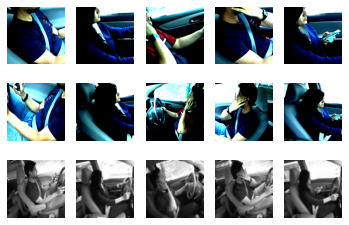

In [ ]:
for i in range(5):
    # View 5 non-augmented training images
    image = train_set[i + 123][0]
    # Place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # Normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, i + 1)
    plt.axis("off")
    plt.imshow(img)

    # View 5 augmented training images
    image_aug = train_set_aug[i + 123][0]
    img_aug = np.transpose(image_aug, [1, 2, 0])
    img_aug = img_aug / 2 + 0.5
    plt.subplot(3, 5, i + 6)
    plt.axis("off")
    plt.imshow(img_aug)

    # View 5 three-channel grayscale training images
    image_grey = train_set_downsize[i + 123][0]
    # Place the colour channel at the end, instead of at the beginning
    img_grey = np.transpose(image_grey, [1, 2, 0])
    # Normalize pixel intensity values to [0, 1]
    img_grey = img_grey / 2 + 0.5
    plt.subplot(3, 5, i + 11)
    plt.axis("off")
    plt.imshow(img_grey)

We can see from the visualization above that though the non-augmented images are center cropped, the key information/pixels remain, e.g., hands, cups, and phones. However, the augmented images sometimes lose more key information.

# Part 2. Model Building and Training  
In this part, we will design our own CNN architectures as well as perform transfer learning by implementing some state-of-the-art CNN's, i.e., VGG16, ResNet18 and AlexNet.  
First, we will check the GPU availability to efficiently train the massive number of images.

In [ ]:
# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device is", device)

Current device is cuda:0


In [ ]:
! nvidia-smi

Sun Apr  3 13:34:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2.0. Helper Functions  
In this section, we define three helper functions.
* ```get_model_name```: generates a name for the model consisting of the batch_size, learning_rate and epoch number.
* ```get_accuracy```: computes the training accuracy, validation accuracy or test accuracy.  
* ```train```: defines the main training loop, including training, validation, checkpointing, and plotting. It also includes a timer for counting the elapsed training time.



In [ ]:
default_path = "/content/gdrive/MyDrive/MIE1517/Models/"

def get_model_name(batch_size, learning_rate, epoch, folder=default_path):
    folder_path = folder # specify your own path
    model_name = "model_bs{0}_lr{1}_epoch{2}".format(batch_size,
                                                     learning_rate,
                                                     epoch)
    path = folder_path + model_name
    
    return path

def get_accuracy(model, downsize=False, single=False, mode='train'):
    if downsize and single:
        if mode == "train":
            data = train_set_down_single
        elif mode == "val":
            data = val_set_down_single
        elif mode == "test":
            data = test_set_down_single
        else:
            print("Please pass a correct argument!")
    elif downsize:
        if mode == "train":
            data = train_set_downsize
        elif mode == "val":
            data = val_set_downsize
        elif mode == "test":
            data = test_set_downsize
        else:
            print("Please pass a correct argument!")
    else:
        if mode == "train":
            data = train_set
        elif mode == "val":
            data = val_set
        elif mode == "test":
            data = test_set
        else:
            print("Please pass a correct argument!")

    correct = 0
    total = 0
    model.eval()  # set to evaluation mode
    if mode != "test":
        for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
            # To enable GPU usage if available
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = model(imgs)
            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
        return correct / total
    else:
        label_list = []
        pred_list = []
        for imgs, labels in tqdm(torch.utils.data.DataLoader(data, batch_size=64,
                                                             num_workers=2)):
            # To enable GPU usage if available
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = model(imgs)
            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            label_list = label_list + labels.tolist()
            pred_list = pred_list + [i[0] for i in pred.tolist()]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
        return correct / total, label_list, pred_list

In [ ]:
def train(model, data, batch_size=64, learning_rate=0.001, num_epochs=100, 
          interval=1, folder=default_path, down=False, single=False):

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               num_workers=2)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []
    train_time = []

    # Training
    n = 0   
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()  # set to training mode
        for imgs, labels in tqdm(iter(train_loader)):
            # To enable GPU usage if available
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)                 # forward pass
            loss = criterion(out, labels)     # compute the total loss
            loss.backward()                   # backward pass (compute parameter updates)
            optimizer.step()                  # make the updates for each parameter
            optimizer.zero_grad()             # a clean up step for PyTorch

        end_time = time.time()
        print("Elapsed time for epoch %d = %0.3f." % (n + 1, end_time - start_time))
        train_time.append(end_time - start_time)

        # Save the current training information
        iters.append(n + 1)
        avg_loss = float(loss) / batch_size                 # compute average loss
        losses.append(avg_loss)                            
        train_acc_epoch = get_accuracy(model, downsize=down, single=single, 
                                       mode="train") # compute training accuracy 
        train_acc.append(train_acc_epoch)
        val_acc_epoch = get_accuracy(model, downsize=down, single=single,
                                     mode="val")     # compute validation accuracy
        val_acc.append(val_acc_epoch)
      
        if (epoch + 1) % interval == 0:
            print(("Epoch %d: Loss: %0.8f, Train acc: %0.8f, Val acc:%0.8f") % (
                epoch + 1,
                avg_loss, 
                train_acc_epoch,
                val_acc_epoch)) 
            # Save the current model (checkpoint) to a file
            model_path = get_model_name(batch_size, learning_rate, epoch, folder=folder)
            torch.save(model.state_dict(), model_path)
        print()
        n += 1
            
    print("Training time per epoch = %0.3f." % np.mean(train_time))
    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc="best")
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

## 2.1. Model 1 (VGG16, by Xinyuan)  
VGG16 architecture is composed of a stack of 16 convolutional layers, where filters with a small kernel size (3x3) are used, and 3 fully-connected layers following the stack of convolutions.  
We select VGG16 because it is one of the best performing architectures and has achieved a top-5 error rate of 7.3% (92.7% accuracy) in ILSVRC — 2014 [Ref.3]. Its detailed architecture is depicted in the following figure.  

<img style="float: left;" src="https://miro.medium.com/max/1400/0*xurYLT8UBpFKPNQA" width=500 height=300> [Ref.3]

In [ ]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

From the architecture above, we can observe that VGG16 is composed of the "features" subnet and "classifier" subnet.  
The pre-trained VGG16 is classifying 1000 ImageNet classes. Hence, we need to modify the code to make the model classify the image into 10 classes but we should re-use the pre-trained convolutional layers by freezing the weights in the "features" subnet. 

In [ ]:
# Modify the output layer
# vgg16.classifier[6].out_features = 10
vgg16.classifier[6] = torch.nn.Linear(4096, 10)

# Freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

```torchsummary.summary``` clearly describes the model architecture, including the output shape and the number of parameters for each layer when the input size is given. It can be seen from the summary below that the VGG16 model has both trainable params and non-trainable params in that we are freezing the convolutional layers in transfer learning.



In [ ]:
torchsummary.summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Recall that we have created two training sets, ```train_set``` contains non-augmented training images while ```train_set_aug``` contains augmented training images. First, we will experiment with training the VGG16 model with non-augmented images. 



100%|██████████| 281/281 [01:41<00:00,  2.76it/s]


Elapsed time for epoch 1 = 102.013.
Epoch 1: Loss: 0.00011750, Train acc: 0.96120185, Val acc:0.95584300



100%|██████████| 281/281 [01:43<00:00,  2.72it/s]


Elapsed time for epoch 2 = 103.397.
Epoch 2: Loss: 0.00010650, Train acc: 0.96889459, Val acc:0.95361285



100%|██████████| 281/281 [01:38<00:00,  2.87it/s]


Elapsed time for epoch 3 = 98.132.
Epoch 3: Loss: 0.00000000, Train acc: 0.98729026, Val acc:0.98126673



100%|██████████| 281/281 [01:43<00:00,  2.72it/s]


Elapsed time for epoch 4 = 103.475.
Epoch 4: Loss: 0.00000000, Train acc: 0.99214003, Val acc:0.98171276



100%|██████████| 281/281 [01:43<00:00,  2.71it/s]


Elapsed time for epoch 5 = 103.981.
Epoch 5: Loss: 0.00000023, Train acc: 0.99643235, Val acc:0.98572703



100%|██████████| 281/281 [01:42<00:00,  2.73it/s]


Elapsed time for epoch 6 = 102.859.
Epoch 6: Loss: 0.00000000, Train acc: 0.99771448, Val acc:0.99063336



100%|██████████| 281/281 [01:41<00:00,  2.76it/s]


Elapsed time for epoch 7 = 101.981.
Epoch 7: Loss: 0.03531885, Train acc: 0.99732427, Val acc:0.98661909



100%|██████████| 281/281 [01:43<00:00,  2.71it/s]


Elapsed time for epoch 8 = 103.726.
Epoch 8: Loss: 0.00000000, Train acc: 0.99743575, Val acc:0.99063336



100%|██████████| 281/281 [01:44<00:00,  2.68it/s]


Elapsed time for epoch 9 = 104.912.
Epoch 9: Loss: 0.00000000, Train acc: 0.99860639, Val acc:0.98795718



100%|██████████| 281/281 [01:52<00:00,  2.50it/s]


Elapsed time for epoch 10 = 112.485.
Epoch 10: Loss: 0.00000000, Train acc: 0.99849490, Val acc:0.98884924

Training time per epoch = 103.696.


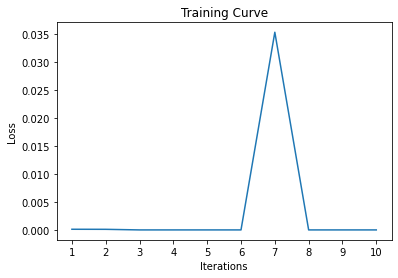

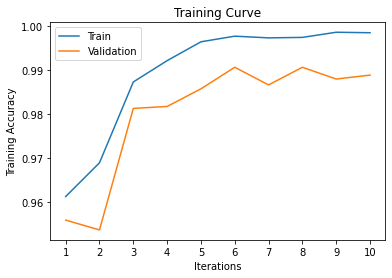

Final Training Accuracy: 0.9984948993812364
Final Validation Accuracy: 0.9888492417484389


In [ ]:
# Training from pre-trained VGG16, without data augmentation
train(vgg16, train_set, num_epochs=10, folder="/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_no_aug/")

Next, we train the VGG16 model with the augmented images.

100%|██████████| 281/281 [02:21<00:00,  1.98it/s]


Elapsed time for epoch 1 = 141.824.
Epoch 1: Loss: 0.02286481, Train acc: 0.52873627, Val acc:0.52586976



100%|██████████| 281/281 [02:22<00:00,  1.97it/s]


Elapsed time for epoch 2 = 143.026.
Epoch 2: Loss: 0.02947666, Train acc: 0.60031217, Val acc:0.59455843



100%|██████████| 281/281 [02:22<00:00,  1.97it/s]


Elapsed time for epoch 3 = 143.101.
Epoch 3: Loss: 0.02087482, Train acc: 0.61402531, Val acc:0.60927743



100%|██████████| 281/281 [02:22<00:00,  1.97it/s]


Elapsed time for epoch 4 = 142.980.
Epoch 4: Loss: 0.02790369, Train acc: 0.63565416, Val acc:0.63380910



100%|██████████| 281/281 [02:21<00:00,  1.98it/s]


Elapsed time for epoch 5 = 142.085.
Epoch 5: Loss: 0.01185902, Train acc: 0.66018173, Val acc:0.66547725



100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Elapsed time for epoch 6 = 143.266.
Epoch 6: Loss: 0.01507377, Train acc: 0.67183232, Val acc:0.68242640



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 7 = 144.343.
Epoch 7: Loss: 0.01933473, Train acc: 0.69446457, Val acc:0.69179304



100%|██████████| 281/281 [02:19<00:00,  2.02it/s]


Elapsed time for epoch 8 = 139.362.
Epoch 8: Loss: 0.02142215, Train acc: 0.71007303, Val acc:0.70963426



100%|██████████| 281/281 [02:21<00:00,  1.99it/s]


Elapsed time for epoch 9 = 141.418.
Epoch 9: Loss: 0.01527322, Train acc: 0.69340543, Val acc:0.68822480



100%|██████████| 281/281 [02:20<00:00,  2.00it/s]


Elapsed time for epoch 10 = 140.731.
Epoch 10: Loss: 0.01482117, Train acc: 0.70990579, Val acc:0.71632471



100%|██████████| 281/281 [02:20<00:00,  2.00it/s]


Elapsed time for epoch 11 = 140.521.
Epoch 11: Loss: 0.01726320, Train acc: 0.69976030, Val acc:0.69313113



100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Elapsed time for epoch 12 = 144.001.
Epoch 12: Loss: 0.02160487, Train acc: 0.70221306, Val acc:0.71454059



100%|██████████| 281/281 [02:22<00:00,  1.97it/s]


Elapsed time for epoch 13 = 142.593.
Epoch 13: Loss: 0.00805790, Train acc: 0.69457606, Val acc:0.69536128



100%|██████████| 281/281 [02:25<00:00,  1.94it/s]


Elapsed time for epoch 14 = 145.210.
Epoch 14: Loss: 0.01559854, Train acc: 0.70544623, Val acc:0.70561998



100%|██████████| 281/281 [02:22<00:00,  1.97it/s]


Elapsed time for epoch 15 = 143.061.
Epoch 15: Loss: 0.01193324, Train acc: 0.72768828, Val acc:0.72881356



100%|██████████| 281/281 [02:18<00:00,  2.04it/s]


Elapsed time for epoch 16 = 138.219.
Epoch 16: Loss: 0.03113909, Train acc: 0.73604995, Val acc:0.74353256



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 17 = 144.542.
Epoch 17: Loss: 0.00907876, Train acc: 0.73699760, Val acc:0.74487065



100%|██████████| 281/281 [02:23<00:00,  1.96it/s]


Elapsed time for epoch 18 = 143.591.
Epoch 18: Loss: 0.01225360, Train acc: 0.72640615, Val acc:0.72479929



100%|██████████| 281/281 [02:24<00:00,  1.94it/s]


Elapsed time for epoch 19 = 144.814.
Epoch 19: Loss: 0.01937329, Train acc: 0.73526952, Val acc:0.74397859



100%|██████████| 281/281 [02:20<00:00,  2.00it/s]


Elapsed time for epoch 20 = 140.623.
Epoch 20: Loss: 0.01514097, Train acc: 0.74842522, Val acc:0.74665477



100%|██████████| 281/281 [02:18<00:00,  2.02it/s]


Elapsed time for epoch 21 = 139.120.
Epoch 21: Loss: 0.00734600, Train acc: 0.73320698, Val acc:0.74308653



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 22 = 144.312.
Epoch 22: Loss: 0.02064078, Train acc: 0.75071074, Val acc:0.75691347



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 23 = 144.618.
Epoch 23: Loss: 0.01906616, Train acc: 0.75567200, Val acc:0.76628011



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 24 = 144.210.
Epoch 24: Loss: 0.01901652, Train acc: 0.75154691, Val acc:0.74977698



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 25 = 144.260.
Epoch 25: Loss: 0.01613118, Train acc: 0.76498133, Val acc:0.76003568



100%|██████████| 281/281 [02:23<00:00,  1.95it/s]


Elapsed time for epoch 26 = 144.119.
Epoch 26: Loss: 0.00733022, Train acc: 0.76899493, Val acc:0.77609277



100%|██████████| 281/281 [02:24<00:00,  1.95it/s]


Elapsed time for epoch 27 = 144.273.
Epoch 27: Loss: 0.01206074, Train acc: 0.75996432, Val acc:0.75958965



100%|██████████| 281/281 [02:21<00:00,  1.99it/s]


Elapsed time for epoch 28 = 141.493.
Epoch 28: Loss: 0.01121949, Train acc: 0.75834773, Val acc:0.76271186



100%|██████████| 281/281 [02:24<00:00,  1.94it/s]


Elapsed time for epoch 29 = 144.748.
Epoch 29: Loss: 0.01218215, Train acc: 0.77272981, Val acc:0.77386262



100%|██████████| 281/281 [02:25<00:00,  1.93it/s]


Elapsed time for epoch 30 = 145.384.
Epoch 30: Loss: 0.00909238, Train acc: 0.76503707, Val acc:0.76851026

Training time per epoch = 142.862.


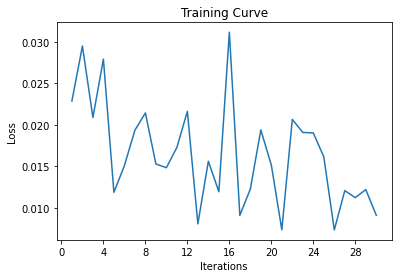

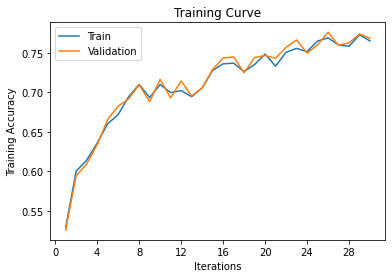

Final Training Accuracy: 0.7650370700707955
Final Validation Accuracy: 0.7685102586975915


In [ ]:
# Training from pre-trained VGG16, regenerate the training set with data augmentation
train(vgg16, train_set_aug, num_epochs=30, folder="/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_aug/")

Both the training accuracy and validation accuracy rise from 95% to 99% within 10 epochs and the final training results are almost perfect with the non-augmented training images.  
However, when the model is trained on the augmented images, the initial accuracies are much lower (40%-50%). And despite the noticeable increase in the accuracies during training, the model achieves an accuracy of around 76% on both the training set and the validation set after 30 epochs, which is much inferior to the results without data augmentation. The loss curve is extraordinarily noisy.  
The difference in the training performance suggests that a better way to do data augmentation is to feed the augmented images along with the raw images to the models in that although data augmentation can improve models' generalization ability, lots of useful/key information is cropped out or ruined when it is performed and so, concatenating the raw images can make up for that loss.

##2.2. Model 2 (ResNet18, by Changda)  
ResNet18 is an 18-layer-deep CNN that belongs to the ResNet family. The highlight of its architecture is *skip connections* that can mitigate exploding or vanishing gradients. The following figure shows the ResNet18 architecture.  

<img style="float: left;" src="https://www.researchgate.net/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png" width=520 height=180> [Ref.4]



In [ ]:
# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained = True)

# resnet18.fc.out_features = 10
resnet18.fc = torch.nn.Linear(512, 10)

# Fine-tuning the fully-connected layer
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True

resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torchsummary.summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

100%|██████████| 281/281 [01:36<00:00,  2.91it/s]


Elapsed time for epoch 1 = 96.753.
Epoch 1: Loss: 0.01603621, Train acc: 0.77077875, Val acc:0.76271186



100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 2 = 92.897.
Epoch 2: Loss: 0.01112864, Train acc: 0.83650148, Val acc:0.83496878



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 3 = 93.154.
Epoch 3: Loss: 0.00876426, Train acc: 0.86381627, Val acc:0.86262266



100%|██████████| 281/281 [01:32<00:00,  3.02it/s]


Elapsed time for epoch 4 = 93.109.
Epoch 4: Loss: 0.00734329, Train acc: 0.87981493, Val acc:0.87912578



100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 5 = 93.380.
Epoch 5: Loss: 0.00638019, Train acc: 0.89179999, Val acc:0.88804639



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 6 = 93.157.
Epoch 6: Loss: 0.00567615, Train acc: 0.89921400, Val acc:0.89384478



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 7 = 93.281.
Epoch 7: Loss: 0.00513465, Train acc: 0.90735270, Val acc:0.90098127



100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 8 = 93.339.
Epoch 8: Loss: 0.00470270, Train acc: 0.91348459, Val acc:0.90544157



100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 9 = 93.542.
Epoch 9: Loss: 0.00434857, Train acc: 0.91822287, Val acc:0.90811775



100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 10 = 93.534.
Epoch 10: Loss: 0.00405207, Train acc: 0.92167902, Val acc:0.91079393



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 11 = 93.189.
Epoch 11: Loss: 0.00379971, Train acc: 0.92463348, Val acc:0.91123996



100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 12 = 92.900.
Epoch 12: Loss: 0.00358210, Train acc: 0.92820113, Val acc:0.91347012



100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Elapsed time for epoch 13 = 93.634.
Epoch 13: Loss: 0.00339242, Train acc: 0.93137856, Val acc:0.91614630



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 14 = 93.119.
Epoch 14: Loss: 0.00322562, Train acc: 0.93349685, Val acc:0.91748439



100%|██████████| 281/281 [01:33<00:00,  3.02it/s]


Elapsed time for epoch 15 = 93.168.
Epoch 15: Loss: 0.00307780, Train acc: 0.93578237, Val acc:0.91703836

Training time per epoch = 93.477.


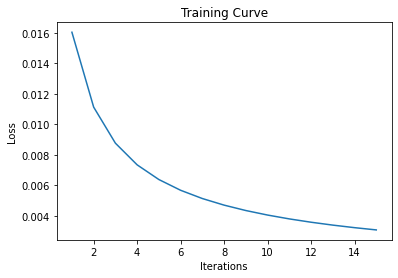

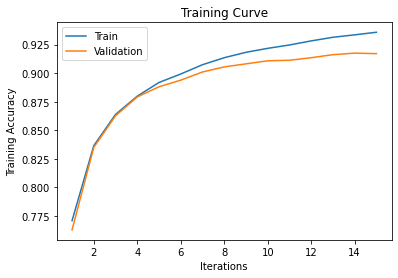

Final Training Accuracy: 0.9357823735994203
Final Validation Accuracy: 0.9170383586083853


In [ ]:
custom_path = "/content/gdrive/MyDrive/MIE1517/Project/Models/ResNet/"

train(resnet18, train_set, num_epochs=15, folder=custom_path)

Using ResNet18, the model achieves a 93.6% training accuracy and 91.7% validation accuracy, which is slightly over-fitting. This shows that the ResNet18 model has effectively learned from the dataset. The training curves are less noisy with the same learning rate and batch size compared with VGG16.  
Generally speaking, a deeper network tends to achieve higher accuracy, but the model faces degradation as the early layer weights tend to vanish as the depth grows. ResNets use skip connections to learn the identity mapping, such that the early layer performs as well as the later layers. 

##2.3. Model 3 (AlexNet, by Seyedeh)  
We are not new to AlexNet, as it was introduced in the lecture and was implemented in Lab2. AlexNet is well-known as the winner of the 2012 ImageNet LSVRC-2012 competition. The highlights of its architecture include [Ref.5], 
* Using ReLU instead of Tanh for activation considerably enhances efficiency.  
* Using dropout instead of regularization to mitigate over-fitting.
* Adding pooling layers to reduce the network size.    
 
The input for AlexNet should be an RGB image. In the above code, the images have been cropped to 224x224 to be suitable to be fed to AlexNet. 
AlexNet has more than 50 million trainable parameters and 650,000 neurons. Also, we know that AlexNet consists of 5 convolutional layers and 3 fully-connected layers. Its detailed architecture is depicted in the following figure. 

<img style="float: left;" src="https://miro.medium.com/max/1400/1*qyc21qM0oxWEuRaj-XJKcw.png" width=500 height=200> [Ref.5]

In [ ]:
# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Now we need to modify the output layer and freeze the weights of all convolutional layers. 

In [ ]:
# Modify the output layer
alexnet.classifier[6] = torch.nn.Linear(4096, 10)

# Freeze convolution weights
for param in alexnet.features.parameters():
    param.requires_grad = False

alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
torchsummary.summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 1 = 93.312.
Epoch 1: Loss: 0.00554383, Train acc: 0.97340989, Val acc:0.96476360



100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Elapsed time for epoch 2 = 93.723.
Epoch 2: Loss: 0.00156546, Train acc: 0.98623112, Val acc:0.97769848



100%|██████████| 281/281 [01:33<00:00,  3.01it/s]


Elapsed time for epoch 3 = 93.358.
Epoch 3: Loss: 0.00169694, Train acc: 0.96705502, Val acc:0.95539697



100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Elapsed time for epoch 4 = 93.852.
Epoch 4: Loss: 0.00182549, Train acc: 0.98901834, Val acc:0.98349688



100%|██████████| 281/281 [01:32<00:00,  3.02it/s]


Elapsed time for epoch 5 = 93.035.
Epoch 5: Loss: 0.00288714, Train acc: 0.98572942, Val acc:0.97190009



100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 6 = 92.963.
Epoch 6: Loss: 0.00000004, Train acc: 0.99297620, Val acc:0.98349688



100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Elapsed time for epoch 7 = 93.644.
Epoch 7: Loss: 0.00242064, Train acc: 0.99470428, Val acc:0.98126673



100%|██████████| 281/281 [01:33<00:00,  3.00it/s]


Elapsed time for epoch 8 = 93.734.
Epoch 8: Loss: 0.00358253, Train acc: 0.99464853, Val acc:0.98349688



100%|██████████| 281/281 [01:34<00:00,  2.97it/s]


Elapsed time for epoch 9 = 94.791.
Epoch 9: Loss: 0.00000000, Train acc: 0.99225152, Val acc:0.98483497



100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 10 = 92.799.
Epoch 10: Loss: 0.00000533, Train acc: 0.99358939, Val acc:0.98706512

Training time per epoch = 93.521.


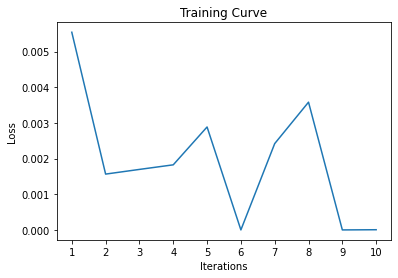

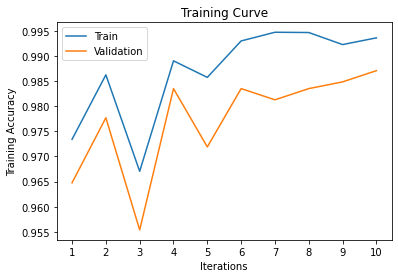

Final Training Accuracy: 0.9935893862534143
Final Validation Accuracy: 0.9870651204281892


In [ ]:
custom_path = "/content/gdrive/MyDrive/MIE1517/Project/Models/AlexNet/"
train(alexnet, train_set, num_epochs=10, folder=custom_path)

We trained the AlexNet model for only 10 epochs on the training dataset since transfer learning enormously accelerated training. The plot above shows that the training accuracy started to be 97.5% and the validation accuracy started from 96.5% and they increased to 99.5% and 98.5%, which were nearly perfect, within the 10 epochs.  
Additionally, the validation accuracy started from 96.4% and it reached 98.7% in the very last epoch. This improvement in accuracy shows a great performance of using AlexNet for our dataset. 

##2.4. Model 4 (3-layer Baseline CNN, by Pai)  
Now, we will design a 3-layers CNN model as our baseline model in which each convolutional layer consists of one convolution that doubles the channels and a "same convolution" that has identical input and output channels. Then it's followed by 3 fully-connected layers where the first two layers are refined by relu activation. And the last fully-connected layer outputs 10 classes.  
The model architecture can be easily engineered to be compatible with various-sized inputs, including large-size RGB images (3x224x224), and downsized grayscale images with 3 output channels (3x64x64), downsized grayscale images with 1 output channel (1x64x64), aligning with the transformations that are defined in section 1.1.

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_filters=32, kernel=3, pad=1, downsize=False, single=False):
    super(CNN, self).__init__()
    self.pool = nn.MaxPool2d((2))
    self.dropout = nn.Dropout(0.3)
    self.downsize = downsize
    self.single = single
    
    # Convolution block 1
    self.conv1 = nn.Sequential(
    # number of input channel depends on the number of output channels in the Grayscale transformation 
    nn.Conv2d(3, num_filters, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters),
    nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters),
    nn.ReLU())

    # Convolution block 1 for single channel input
    self.conv1_single = nn.Sequential(
    nn.Conv2d(1, num_filters, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters),
    nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters),
    nn.ReLU())

    # Convolution block 2
    self.conv2 = nn.Sequential(
    nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters*2),
    nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters*2),
    nn.ReLU())

    # Convolution block 3
    self.conv3 = nn.Sequential(
    nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters*4),
    nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=pad),
    nn.BatchNorm2d(num_filters*4),
    nn.ReLU())
    
    # FC 1
    self.fc1 = nn.Linear(28*28*128, 512)
    self.fc1_down = nn.Linear(8*8*128, 512)
    # FC 2
    self.fc2 = nn.Linear(512, 128)
    # FC 3
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
      if self.single:
          x = self.conv1_single(x)
      else:
          x = self.conv1(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv2(x)
      x = self.pool(x)
      x = self.dropout(x)

      x = self.conv3(x)
      x = self.pool(x)
      x = self.dropout(x)

      if self.downsize:
          x = x.view(-1, 8*8*128)
          x = F.relu(self.fc1_down(x))
      else:
          x = x.view(-1, 28*28*128)       
          x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      
      return x

The sanity check tests whether the architecture works properly when receiving the three sizes of inputs. For a batch size of 2, the model outputs under the three circumstances are [2, 10], which are correct for predicting from 10 classes.

In [ ]:
# Sanity check
# For Grayscale transformation output channels = 3
test = CNN()
inputs = torch.randn((2, 3, 224, 224))
y = test(inputs)
print(y.shape)

test_down = CNN(downsize=True)
inputs_down = torch.randn((2, 3, 64, 64))
y_down = test_down(inputs_down)
print(y_down.shape)

# For Grayscale transformation output channels = 1
test = CNN(downsize=True, single=True)
inputs = torch.randn((2, 1, 64, 64))
y = test(inputs)
print(y.shape)

torch.Size([2, 10])
torch.Size([2, 10])
torch.Size([2, 10])


We display the model architecture visually in the below in which the model receives 3x224x224 image inputs taking advantage of *Netron*.

<img style="float: left;" src="https://drive.google.com/uc?id=1mxJjhMHUsTbUoMyPiLhibNAE0mfLaMzJ" width=450 height=500>

In [ ]:
cnn = CNN(downsize=True, single=True)
cnn.to(device)
print(cnn)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=None)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv1_single): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [ ]:
torchsummary.summary(cnn, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 32, 64, 64]           9,248
       BatchNorm2d-4           [-1, 32, 64, 64]              64
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
           Dropout-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
          Dropout-14           [-1, 64,

The summary above shows that the baseline CNN model with input size 1x64x64 (downsized single-channel grayscale images) has the fewest number of trainable hyperparameters among all our models. So ideally, it should be the most computationally-efficient model to train but may lead to an inferior performance.

100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 1 = 92.983.
Epoch 1: Loss: 0.00694995, Train acc: 0.79012208, Val acc:0.78010705



100%|██████████| 281/281 [01:32<00:00,  3.03it/s]


Elapsed time for epoch 2 = 92.746.
Epoch 2: Loss: 0.00336491, Train acc: 0.93918279, Val acc:0.93621766



100%|██████████| 281/281 [01:32<00:00,  3.02it/s]


Elapsed time for epoch 3 = 92.991.
Epoch 3: Loss: 0.00045677, Train acc: 0.97814817, Val acc:0.97190009



100%|██████████| 281/281 [01:32<00:00,  3.04it/s]


Elapsed time for epoch 4 = 92.447.
Epoch 4: Loss: 0.00028962, Train acc: 0.98021071, Val acc:0.97145406



100%|██████████| 281/281 [01:32<00:00,  3.04it/s]


Elapsed time for epoch 5 = 92.526.
Epoch 5: Loss: 0.00166161, Train acc: 0.98193879, Val acc:0.97413024

Training time per epoch = 92.739.


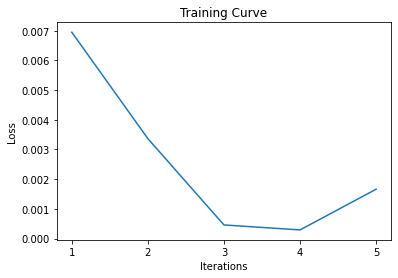

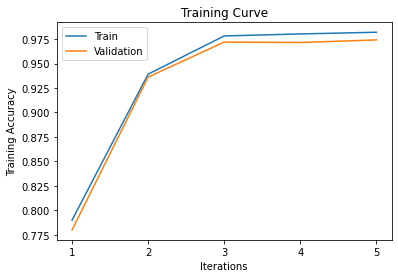

Final Training Accuracy: 0.981938792574837
Final Validation Accuracy: 0.9741302408563782


In [ ]:
custom_path = "/content/gdrive/MyDrive/MIE1517/Project/Models/Baseline_down_single/"
train(cnn, train_set_down_single, num_epochs=5, folder=custom_path, 
      down=True, single=True)

100%|██████████| 281/281 [01:45<00:00,  2.67it/s]


Elapsed time for epoch 1 = 105.349.
Epoch 1: Loss: 0.00965384, Train acc: 0.74842522, Val acc:0.74397859



100%|██████████| 281/281 [01:42<00:00,  2.74it/s]


Elapsed time for epoch 2 = 102.755.
Epoch 2: Loss: 0.00170303, Train acc: 0.93974023, Val acc:0.92863515



100%|██████████| 281/281 [01:41<00:00,  2.76it/s]


Elapsed time for epoch 3 = 102.030.
Epoch 3: Loss: 0.00112889, Train acc: 0.97190479, Val acc:0.95495094



100%|██████████| 281/281 [01:42<00:00,  2.74it/s]


Elapsed time for epoch 4 = 102.627.
Epoch 4: Loss: 0.00010751, Train acc: 0.97625286, Val acc:0.95004460



100%|██████████| 281/281 [01:42<00:00,  2.75it/s]


Elapsed time for epoch 5 = 102.323.
Epoch 5: Loss: 0.00036792, Train acc: 0.97948604, Val acc:0.96610169



100%|██████████| 281/281 [01:42<00:00,  2.75it/s]


Elapsed time for epoch 6 = 102.414.
Epoch 6: Loss: 0.00006155, Train acc: 0.97368861, Val acc:0.95941124



100%|██████████| 281/281 [01:42<00:00,  2.74it/s]


Elapsed time for epoch 7 = 102.611.
Epoch 7: Loss: 0.00002373, Train acc: 0.99241875, Val acc:0.97457627



100%|██████████| 281/281 [01:42<00:00,  2.75it/s]


Elapsed time for epoch 8 = 102.252.
Epoch 8: Loss: 0.00002035, Train acc: 0.99007748, Val acc:0.97546833



100%|██████████| 281/281 [01:42<00:00,  2.74it/s]


Elapsed time for epoch 9 = 102.692.
Epoch 9: Loss: 0.00002013, Train acc: 0.98756898, Val acc:0.96743979



100%|██████████| 281/281 [01:42<00:00,  2.74it/s]


Elapsed time for epoch 10 = 102.595.
Epoch 10: Loss: 0.00014704, Train acc: 0.99180556, Val acc:0.96877788

Training time per epoch = 102.765.


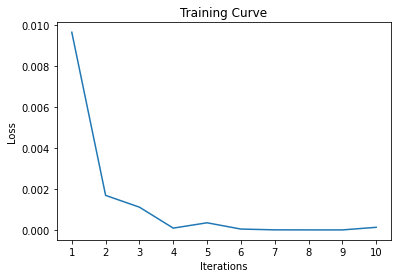

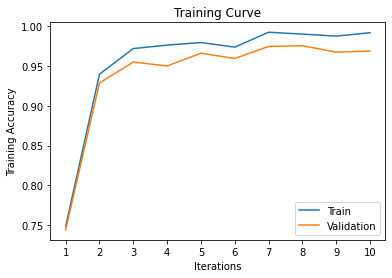

Final Training Accuracy: 0.9918055632978426
Final Validation Accuracy: 0.9687778768956289


In [ ]:
cnn_full = CNN()
cnn_full.to(device)

custom_path = "/content/gdrive/MyDrive/MIE1517/Project/Models/Baseline/"
train(cnn_full, train_set, num_epochs=10, folder=custom_path)

100%|██████████| 281/281 [02:06<00:00,  2.21it/s]


Elapsed time for epoch 1 = 126.983.
Epoch 1: Loss: 0.01074095, Train acc: 0.83003512, Val acc:0.82694023



100%|██████████| 281/281 [02:21<00:00,  1.99it/s]


Elapsed time for epoch 2 = 141.319.
Epoch 2: Loss: 0.00110400, Train acc: 0.92597135, Val acc:0.92149866



100%|██████████| 281/281 [02:20<00:00,  2.00it/s]


Elapsed time for epoch 3 = 140.353.
Epoch 3: Loss: 0.00365621, Train acc: 0.97095713, Val acc:0.95807315



100%|██████████| 281/281 [02:19<00:00,  2.02it/s]


Elapsed time for epoch 4 = 139.316.
Epoch 4: Loss: 0.00291658, Train acc: 0.98249624, Val acc:0.96342551



100%|██████████| 281/281 [02:08<00:00,  2.19it/s]


Elapsed time for epoch 5 = 128.644.
Epoch 5: Loss: 0.00197169, Train acc: 0.98355538, Val acc:0.97190009



100%|██████████| 281/281 [02:18<00:00,  2.02it/s]


Elapsed time for epoch 6 = 139.070.
Epoch 6: Loss: 0.00005764, Train acc: 0.98160433, Val acc:0.97323818



100%|██████████| 281/281 [02:15<00:00,  2.07it/s]


Elapsed time for epoch 7 = 135.951.
Epoch 7: Loss: 0.00027013, Train acc: 0.98912983, Val acc:0.97769848



100%|██████████| 281/281 [02:20<00:00,  2.01it/s]


Elapsed time for epoch 8 = 140.178.
Epoch 8: Loss: 0.00048463, Train acc: 0.98823792, Val acc:0.97636039



100%|██████████| 281/281 [02:20<00:00,  2.00it/s]


Elapsed time for epoch 9 = 140.715.
Epoch 9: Loss: 0.00011605, Train acc: 0.98634261, Val acc:0.97502230



100%|██████████| 281/281 [02:19<00:00,  2.01it/s]


Elapsed time for epoch 10 = 139.877.
Epoch 10: Loss: 0.00002894, Train acc: 0.99308769, Val acc:0.98483497

Training time per epoch = 137.241.


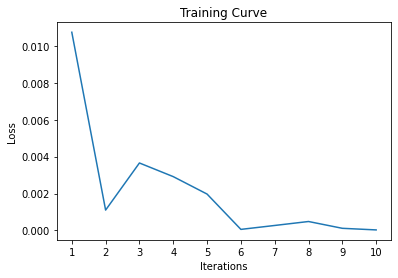

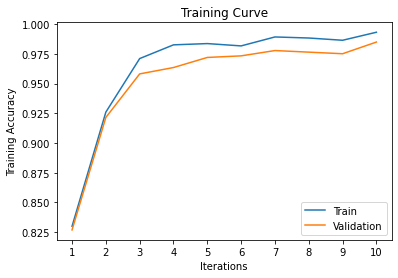

Final Training Accuracy: 0.9930876860471598
Final Validation Accuracy: 0.9848349687778769


In [ ]:
cnn_down = CNN(downsize=True)
cnn_down.to(device)

custom_path = "/content/gdrive/MyDrive/MIE1517/Project/Models/Baseline_down/"
train(cnn_down, train_set_downsize, num_epochs=10, folder=custom_path, down=True)

As we have mentioned before, downsizing and greyscaling the input images  should have had negatively affected the performance as less information is provided. However, the CNN model actually performed surprisingly well as it was still on par with the performance of pre-trained VGG16 and ResNet18 even though the two pre-trained models were much more complicated. And it turns out that taking the downsized grayscale images as inputs is the most sensible way to train the model as it is the most computationally-efficient model exhibiting impressive performance.

# Part 3. Model Testing and Evaluation
In this part, we would like to compare the performance of all the models we have. Two Numerical metrics, test accuracy and confusion matrix will be used as quantitative analysis. The test accuracy tells the models' overall performance whereas the confusion matrices show the predictions vs. true labels per image class.
We will also use Gradient-weighted Class Activation Mapping (Grad-CAM), which is one of the explainable AI techniques that can visualize feature importance to the output on the original images, to analyze the results qualitatively.   
PyTorch Grad-CAM Library: https://github.com/jacobgil/pytorch-grad-cam

## 3.0. Preparation  
Several libraries will be installed to enable to usage of Grad-CAM and YouTube videos.

In [ ]:
! pip install grad-cam

     |████████████████████████████████| 4.5 MB 7.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=c1b21f82463399035bb88a376f82c7e1e41f5c3f1120b82f119bf1b92005344b
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


In [ ]:
! pip install pytube

     |████████████████████████████████| 56 kB 3.4 MB/s 


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import cv2 as cv

import glob
from IPython.display import YouTubeVideo
from pytube import YouTube

## 3.1. Helper Functions  
We will design three helper functions as follows.  
* ```display_heatmap``` draws a heatmap of a confusion matrix to show contrast in the predictions vs. true labels and it is called by the function ```test```.
* ```test``` reports the test accuracy and draws the confusion matrix.
* ```generate_gradCAM``` generates the heatmap, i.e., the gradient-weighted class activation map of the class associated with the highest prediction probability for a given model on any input images.



In [ ]:
def display_heatmap(labels, preds):
    plt.figure(figsize=(8, 16))
    plt.subplot(1, 2, 1)
    x_tick_labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    y_tick_labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    sns.heatmap(confusion_matrix(labels, preds), 
                annot=True, fmt="d",cmap="Blues", 
                square=True, cbar=False, 
                xticklabels=x_tick_labels,
                yticklabels=y_tick_labels)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    plt.show()


def test(model_path):
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    print("Model loaded!")
    # Compute test accuracy
    test_acc, label_list, pred_list = get_accuracy(model, downsize=False, mode="test")
    print("The test accuracy is %0.4f." % test_acc)
    # Display confusion matrix as heatmap
    display_heatmap(label_list, pred_list)
    return test_acc


def generate_gradCAM(image_path, model, target_layers):
    # Open the image
    rgb_img = Image.open(image_path)

    crop = transforms.CenterCrop(224)
    crop_img = crop(rgb_img).convert("RGB")

    tensor_img_crop = torchvision.transforms.functional.to_tensor(crop_img)
    tensor_img_crop = torchvision.transforms.functional.normalize(tensor_img_crop, 
                                                             [0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225]).unsqueeze(0).float().to(device)
                                                        

    crop_img = (crop_img - np.min(crop_img)) / (np.max(crop_img) - np.min(crop_img))

    # Show the prediction
    output = model(tensor_img_crop)
    pred = F.softmax(output, dim=1)
    print("Predicted label:", pred.max(1, keepdim=True)[1].cpu().item())

    # Construct the CAM object once, and then re-use it on many images
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

    # Set targets = None, then we generate the Class Activation Maps for the class with the highest probability

    grayscale_cam = cam(input_tensor=tensor_img_crop, targets=None).transpose(1, 2, 0)

    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(crop_img, grayscale_cam, use_rgb=True)

    res = Image.fromarray(visualization, "RGB")
    plt.imshow(res)
    plt.axis("off")
    plt.show()

## 3.2. Show test accuracies and confusion matrices

In the following cell, we will load all the trained models, specify their architectures, and pass each of them to the pre-defined ```test``` function so that the overall test accuracies and confusion matrices will be computed automatically.

Evaluating the model VGG16 without Augmentation
Model loaded!


100%|██████████| 36/36 [04:02<00:00,  6.75s/it]


The test accuracy is 0.9884.


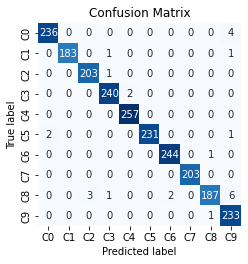

Evaluating the model VGG16 with Augmentation
Model loaded!


100%|██████████| 36/36 [00:14<00:00,  2.53it/s]


The test accuracy is 0.7744.


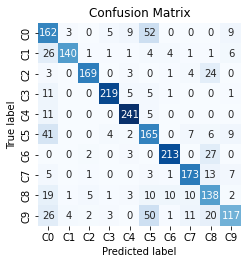

Evaluating the model ResNet18
Model loaded!


100%|██████████| 36/36 [00:12<00:00,  2.88it/s]


The test accuracy is 0.9086.


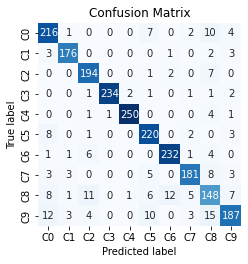

Evaluating the model AlexNet
Model loaded!


100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


The test accuracy is 0.9848.


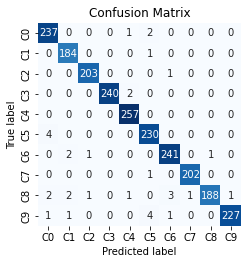

Evaluating the model Baseline
Model loaded!


100%|██████████| 36/36 [00:13<00:00,  2.64it/s]


The test accuracy is 0.9884.


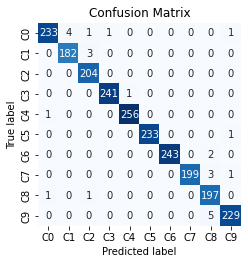

In [ ]:
# List all the model paths
model_paths = ["/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_no_aug/model_bs64_lr0.001_epoch9",  # VGG16 without aug
               "/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_aug/model_bs64_lr0.001_epoch29",    # VGG16 with aug
               "/content/gdrive/MyDrive/MIE1517/Project/Models/ResNet/model_bs64_lr0.001_epoch9",      # ResNet18
               "/content/gdrive/MyDrive/MIE1517/Project/Models/AlexNet/model_bs64_lr0.001_epoch9",     # AlexNet
               "/content/gdrive/MyDrive/MIE1517/Project/Models/Baseline/model_bs64_lr0.001_epoch9"]    # Baseline 

# List all the model architectures
vgg_model = models.vgg16()
vgg_model.classifier[6] = torch.nn.Linear(4096, 10)
resnet_model = models.resnet18()
resnet_model.fc = torch.nn.Linear(512, 10)
alexnet_model = models.alexnet()
alexnet_model.classifier[6] = torch.nn.Linear(4096, 10)

model_architects = [vgg_model, vgg_model, 
                    resnet_model, alexnet_model, CNN()]

# List all the model names
model_names = ["VGG16 without Augmentation", "VGG16 with Augmentation", 
               "ResNet18", "AlexNet", "Baseline"]

test_accs = []
for model_name, model_path, model_archi in zip(model_names, model_paths, model_architects):
    print("Evaluating the model", model_name)
    model = model_archi
    test_acc = test(model_path)
    test_accs.append(test_acc)

There are some noteworthy patterns shown in the confusion matrices above. Both the ResNet18 model and the AlexNet model are more likely to misclassify the images from C8 and C9 whereas the baseline CNN model is poor at handling images from C1, C7 and C8. The VGG16 model trained with augmented images suffers from high false negativities, meaning that it occasionally fails to detect distracted driving behaviours. This is especially undesirable when the model is implemented in real applications. Generally speaking, C8: hair and makeup is the trickiest category for the models to make a correct prediction.  
We summarize the test accuracies in a bar plot as follows, which reflects that except for the VGG16 model trained with augmented images, all the rest four models achieve impressive test accuracies. The VGG16 model shows much inferior performance because a large amount of information has been lost when random cropping or rotation is applied to the training set. The reason why the ResNet18 model has the second-lowest test accuracy is that it has the fewest trainable parameters, which might be insufficient, when all its convolutional layers are frozen.

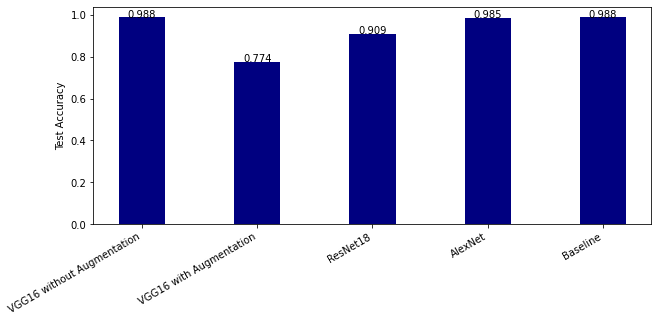

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(range(len(test_accs)), test_accs,
        width=0.4, color="navy")
for xx, yy in zip(range(len(test_accs)), test_accs):
   plt.text(xx, yy, str(round(yy, 3)), ha='center')
plt.xticks(range(len(test_accs)), model_names, rotation=30, ha='right')
plt.ylabel("Test Accuracy")
plt.show()

## 3.3 Visualization using Grad-CAM  
Let's talk more about explainable AI and Grad-CAM. 
In contrast to the concept of "black box" of deep learning, explainable AI (XAI) is artificial intelligence which aims at generating results that can be understood by humans.[Ref.6] By enabling the models to be interpretable, explainable AI helps uncover data biases and enhances the models' reliability as well as transparency. There are various ways of approaching this problem and the best-known solutions include,
* Model-Agnostic approaches, e.g., LIME, SHAP
* Backpropagation approaches
* CAM-based methods, e.g., Grad-CAM, AblationCAM
* Perturbation-based methods, e.g., RISE, SISE  

In the following sections, we will look into the decision-making of our models using **Grad-CAM**. Grad-CAM uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image [Ref 2]. Grad-CAM features its applicability to a wide variety of CNN models, making it possible to be applied to all the models we have built as long as the final convolutional layer is specified.  
The figure [Ref.7] below depicts the workflow of Grad-CAM. The resulting heatmaps that highlight the important features are generated by scoring the feature maps in the last convolutional layer with the "average gradients", which are calculated by backpropagating the output signals.  

<img style="float: left;" src="https://media.arxiv-vanity.com/render-output/5554606/figures/grad-cam_approach.jpg" width=600 height=250>

We select some images from 3 typical classes of distracted driving behaviours for visualization.

In [ ]:
img_path_c2 = "/content/gdrive/MyDrive/MIE1517/Project/Datasets/train/c2/img_101373.jpg"  
img_path_c3 = "/content/gdrive/MyDrive/MIE1517/Project/Datasets/train/c3/img_101906.jpg"  
img_path_c6 = "/content/gdrive/MyDrive/MIE1517/Project/Datasets/train/c6/img_102074.jpg" 

We evaluate VGG16 trained with non-augmented images on the three images.

In [ ]:
model_path_vgg_na = "/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_no_aug/model_bs64_lr0.001_epoch9"
vgg_model_na = models.vgg16()
vgg_model_na.classifier[6] = torch.nn.Linear(4096, 10)
vgg_model_na.to(device)
vgg_model_na.load_state_dict(torch.load(model_path_vgg_na))

# Extract the last convolutional layer
target_layers_vgg_na = [vgg_model_na.features[-1]]

True label: C2
Predicted label: 2


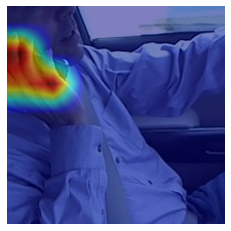

True label: C3
Predicted label: 3


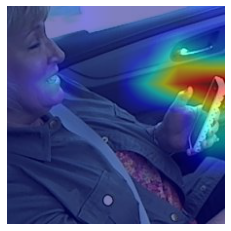

True label: C6
Predicted label: 6


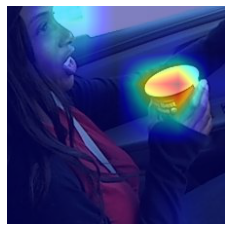

In [ ]:
# Image from C2
print("True label: C2")
generate_gradCAM(img_path_c2, vgg_model_na, target_layers_vgg_na)
# Image from C3
print("True label: C3")
generate_gradCAM(img_path_c3, vgg_model_na, target_layers_vgg_na)
# Image from C6
print("True label: C6")
generate_gradCAM(img_path_c6, vgg_model_na, target_layers_vgg_na)

Similarly, we evaluate the VGG16 model trained with augmented images and the ResNet18 model on the same set of images.

In [ ]:
model_path_vgg_a = "/content/gdrive/MyDrive/MIE1517/Project/Models/VGG_aug/model_bs64_lr0.001_epoch29"
vgg_model_a = models.vgg16()
vgg_model_a.classifier[6] = torch.nn.Linear(4096, 10)
vgg_model_a.to(device)
vgg_model_a.load_state_dict(torch.load(model_path_vgg_a))

# Extract the last convolutional layer
target_layers_vgg_a = [vgg_model_a.features[-1]]

True label: C2
Predicted label: 2


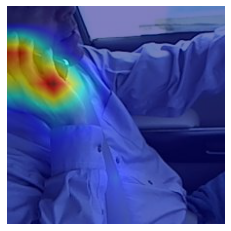

True label: C3
Predicted label: 3


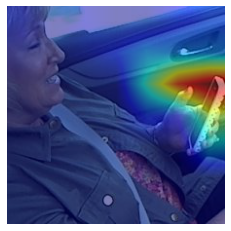

True label: C6
Predicted label: 6


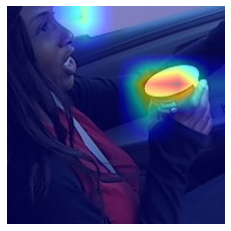

In [ ]:
# Image from C2
print("True label: C2")
generate_gradCAM(img_path_c2, vgg_model_a, target_layers_vgg_a)
# Image from C3
print("True label: C3")
generate_gradCAM(img_path_c3, vgg_model_a, target_layers_vgg_a)
# Image from C6
print("True label: C6")
generate_gradCAM(img_path_c6, vgg_model_a, target_layers_vgg_a)

In [ ]:
model_path_resnet = "/content/gdrive/MyDrive/MIE1517/Project/Models/ResNet/model_bs64_lr0.001_epoch9"
# model_path_resnet = "/content/gdrive/MyDrive/MIE1517/model_bs64_lr0.001_epoch19"
resnet_model = models.resnet18()
resnet_model.fc = torch.nn.Linear(512, 10)
resnet_model.to(device)
resnet_model.load_state_dict(torch.load(model_path_resnet))

# Extract the last convolutional layer
target_layers_resnet = [resnet_model.layer4[-1]]

True label: C2
Predicted label: 8


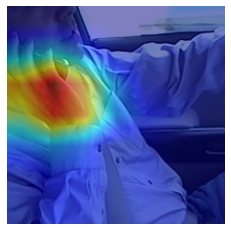

True label: C3
Predicted label: 3


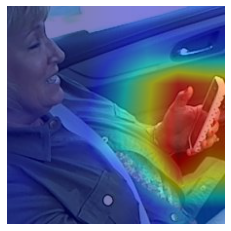

True label: C6
Predicted label: 6


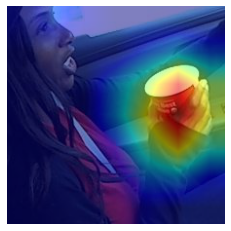

In [ ]:
# Image from C2
print("True label: C2")
generate_gradCAM(img_path_c2, resnet_model, target_layers_resnet)
# Image from C3
print("True label: C3")
generate_gradCAM(img_path_c3, resnet_model, target_layers_resnet)
# Image from C6
print("True label: C6")
generate_gradCAM(img_path_c6, resnet_model, target_layers_resnet)

Coupled with the three sets of figures above, we learn that all the three models predict that the driver in the C2 image is talking on the phone by looking at his hand gesture. And the models know that the driver in the C3 image is texting while the driver in the C6 image is drinking in that they find the cell phone and the cup, respectively.  
The Grad-CAM results also visually explain how decision-making varies from model to model. From the above figures, we can safely conclude that compared with the VGG16 models, the ResNet18 model focuses on larger regions when making the same predictions.
 

##3.4. Demonstration on the Real-World Data  
To demonstrate our trained model, we first used the images from the "test" folder on Kaggle. Those images were unlabeled and had never been exposed to the training pipeline. To make it easier for visualization and model evaluation, we processed each image and embedded it with a list of labels with probabilities.  
We tried all the models we had trained and it turned out **the VGG16 model trained with data augmentation** yielded the most accurate predictions. Thus, we picked this model for the demonstration. Firstly, we resized the images to the same dimension as we used while training. Secondly, the same normalization was then applied. OpenCV library was used to draw the embedded prediction results and video creations.

In [ ]:
image_list = []
image_cnt = 0

model_path_vgg_a = "/content/gdrive/MyDrive/Models/VGG_aug/model_bs64_lr0.001_epoch19"
vgg_model_a = models.vgg16()
vgg_model_a.classifier[6] = torch.nn.Linear(4096, 10)
vgg_model_a.to(device)
vgg_model_a.load_state_dict(torch.load(model_path_vgg_a))

model_path_vgg_rs = "/content/gdrive/MyDrive/Models/VGG_resize/model_bs64_lr0.001_epoch1"
vgg_model_rs = models.vgg16()
vgg_model_rs.classifier[6] = torch.nn.Linear(4096, 10)
vgg_model_rs.to(device)
vgg_model_rs.load_state_dict(torch.load(model_path_vgg_rs))


# Transfomer, should be the same when training the models
transforms_m = torch.nn.Sequential(
    # transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

test_model = vgg_model_rs

# Output location of the video
out = cv.VideoWriter('outputVGG.avi',
                     cv.VideoWriter_fourcc('M','J','P','G'), 0.5, (640, 480))

for filename in tqdm(glob.glob('/content/gdrive/MyDrive/MIE1517/test2/*.jpg')): #assuming gif
    frame = cv.imread(filename)
    img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    img_rgb = cv.rotate(img_rgb, cv.ROTATE_90_COUNTERCLOCKWISE)
    img_rgb = cv.flip(img_rgb, 0)
    img = torch.tensor(img_rgb/255, dtype=torch.float)
    img = torch.transpose(img, 0, 2)
    img_tensor = transforms_m(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)
    output = F.softmax(test_model(img_tensor))
    pred = output.max(1, keepdim=True)[1]
    largest = -999
    largest_index = 0
    for i in enumerate(output.cpu()[0]):
        key = "C" + str(i[0])
        if(i[1].item() > largest):
            largest = i[1].item()
            largest_index = i[0]
        # Display the selected model name
        frame = cv.putText(frame, "VGG", (10, 460), font, 0.4, (0, 255, 255), 1, cv.LINE_AA)
        # Display the probabilities and the final prediction
        frame = cv.putText(frame, key + ": " + result_dictionary[key] + ' ' +  '{0:.3f}'.format(i[1].item()), (10,i[0] * 20 + 20), font, 0.4, (0, 255, 255), 1, cv.LINE_AA)
    frame = cv.circle(frame, (2, largest_index * 20 + 15), 5, (0,0,255), -1)
    
    out.write(frame)

out.release()


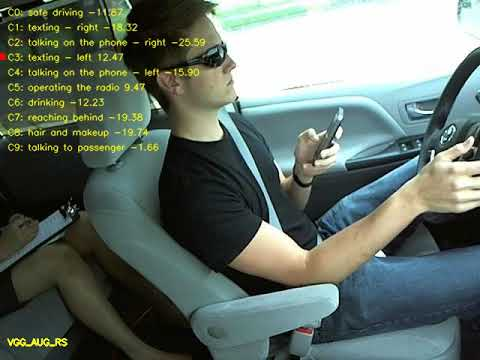

In [ ]:
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('P2vc2qBzPPQ')

The video on the top is our visualization of the results on the Kaggle "test" folder images and labels with a red dot are our predictions.
Generally speaking, the model demonstrates a robust classification of distracted driving behaviors, especially for the categories such as reaching back or texting. The result also suggests that it can handle diverse lighting conditions or orientations. This is mainly due to the augmentations and normalizations of the images before feeding them into the training pipeline.
However, there still exist a few false positivities and erroneous predictions between drinking and holding a phone, where those two objects are similar in shape.

In [ ]:
print(os.path.isfile('/content/IMG_0084.mov'))

capture = cv.VideoCapture('/content/IMG_0084.mov')
if(capture.isOpened()==False):
    print("Unable to open the video")

cnt = 0
while(capture.isOpened()):
    ret, frame = capture.read()
    if ret == True:
        cv.imshow('Frame', frame)

capture.release()

To further evaluate our models, we applied them to a real-world video that was taken through a dashcam mounted in the car. This was intended to test the model performance in real-world scenarios and to see if the model could be applied to live driving, which exactly aligned with our motivation to pick this topic, with image streams and formats different from the training data. The video was read using the OpenCV library and every single frame was passed through the same pre-defined transformations as we did in training.

In [ ]:
# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained = True)
model_resnet= "/content/gdrive/MyDrive/Models/ResNet/model_bs64_lr0.001_epoch9"
resnet18.fc = torch.nn.Linear(512, 10)
resnet18.load_state_dict(torch.load(model_resnet))
resnet18.to(device)

model_path_vgg_a = "/content/gdrive/MyDrive/Models/VGG_aug/model_bs64_lr0.001_epoch19"
vgg_model_a = models.vgg16()
vgg_model_a.classifier[6] = torch.nn.Linear(4096, 10)
vgg_model_a.to(device)
vgg_model_a.load_state_dict(torch.load(model_path_vgg_a))


# Transfomer, should be the same when training the models
transforms = torch.nn.Sequential(
    # transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)

print(os.path.isfile('/content/test3.mp4'))

# Change the capture to you want. 
capture = cv.VideoCapture('/content/test3.mp4')

# Load your models
test_model = vgg_model_a

# Output location of the video
out = cv.VideoWriter('output2.avi', 
                     cv.VideoWriter_fourcc('X','I','V','D'), 5, (300, 360))

font = cv.FONT_HERSHEY_SIMPLEX

if(capture.isOpened()==False):
  print("Unable to open the video")

# A sampler to capture a result for each cateogry
result_dictionary = {"C0": "safe driving", 
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger"}

# How Many Frame to process. Typically 6000 frame with 640*360 take about 3-4 minute to process
NUM_Frames = 6000
for i in tqdm(range(NUM_Frames)):
    if(capture.isOpened()):
        ret, frame = capture.read()
        if(i == 1):
            out.write(frame)
        if ret == True:
            #frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)
            img = torch.tensor(frame/255, dtype=torch.float)
            img = torch.transpose(img, 0, 2)
            img_tensor = transforms(img)
            img_tensor = img_tensor.unsqueeze(0).to(device)
            output = test_model(img_tensor)
            # output = F.softmax(output, dim=1)
            pred = output.max(1, keepdim=True)[1]
            largest = -999
            largest_index = 0
            for i in enumerate(output.cpu()[0]):
                key = "C" + str(i[0])
                if(i[1].item() > largest):
                    largest = i[1].item()
                    largest_index = i[0]
                frame = cv.putText(frame, result_dictionary[key] + ": " +  '{0:.2f}'.format(i[1].item()), (10,i[0] * 10), font, 0.4, (0, 255, 0), 1, cv.LINE_AA)
            frame = cv.circle(frame, (5, largest_index * 10), 3, (0,0,255), -1)
        out.write(frame)
capture.release()


True


100%|██████████| 6000/6000 [00:19<00:00, 311.19it/s] 


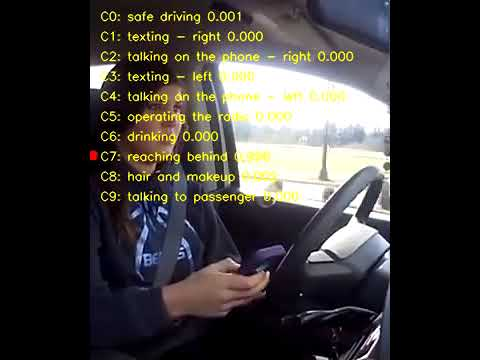

In [ ]:
YouTubeVideo('kNQCSHJghWo')

The **highlights** in the demonstrations include:  
* Robust distracted behavior detection on still images.
* Low-latency processing (prediction time < 10ms) makes real-time prediction and streaming possible.

The demonstration on the real-world video reflects a bunch of **challenges** in making correct predictions:  
* Requires a fixed camera angle, making it less compatible with different viewpoints or scenarios.
* The classifications of specific classes (drinking vs. talking to the phone) need to be improved.
* More likely to make a false prediction when there is a movement and those false predictions typically lie in a motion category. Such as reaching to the back or touching the hair.


# Part 4. Related Work

* The paper *Detection of Distracted Driver using Convolutional Neural Network* [Ref.8] studies the same topic and suggests a similar approach which uses VGG16. They modify the VGG16 architecture and study the impacts of various regularization techniques. This research achieve a descent accuracy of 96.31%; nonetheless,it does not touch upon the effects of the data augmentation which we have found is a vital section on generalizing the inputs. 

* In *An Efficient Deep Learning Framework for Distracted Driver Detection* [Ref.9], the team worked on the same dataset suggested EfficientNet, which achieved a accuracy of around 99.16%. The pipeline is shown in the following figure. The highlight of this research is that it employs an object detector to locate the region of interest of the body parts that involve driving from the full images, which significantly improves the prediction qualities and is more reasonable than center-cropping or resizing in our approach. However, a longer training time is expected. A Bidirectional Feature Pyramid Network (BiFPN) is introduced which allows fast features fusion. 

<img style="float: left;" src="https://ieeexplore.ieee.org/mediastore_new/IEEE/content/media/6287639/9312710/9662336/javed2-3138137-small.gif" width=500 height=250>  

* In *Real-time Detection of Distracted Driving Based on Deep Learning* [Ref.10], the team follows a similar procedure as ours and validates that their implementation can be applied to real-time detection by further developing a conversational warning system that alerts the driver in real-time when he/she does not focus on the driving task. Compared with our project, their work is closer to a pratical application.

# Part 5. Conclusions and Further Discussions

In conclusion, we find out that both the 3-layer baseline CNN and VGG16(no augmentation) are the most competitive models for our specific task with AlexNet following closely. Leveraging heatmap-based explainable AI, we realize that different models tend to focus on varying regions of interest and emphasize different pixels. The distinction is significant and can be utilized to select a model when we seek to prioritize exploring a specific area. 

Data pre-processing has played a crucial role in our project. Originally it is only applied to match the dimensions of inputs to the transfer learning models. However, after investigating the cropped image, we realize that cropping does more than that -- it gives a more concentrated image that contains just sufficient information to make a good prediction. In addition to that, when facing a similar task, one might also want to consider the option to resize the inputs to reduced resolutions and transform them into different color spaces as well for accelerating training. In our case, 64x64, grayscale images are fed to the baseline CNN and it is far from compromising the performance -- as it yields promising performance just as the other more complicated models with higher-resolution inputs. But of course, this is case-dependent so one needs to carefully investigate the data and task to see if such a method fits.  

As to explain the overall descent performance for all models, we think it is due to there being plenty of training data available and the pattern is easier to locate in our task. To be more specific, since all images are captured by dashcams, they are all from identical viewpoints which greatly reduces barriers to training. Plus, the object (human) is always located in the center and the head and hands that the models look for are normally placed in a specific area. Moreover, the driver's cabin is a rather simple and consistent background. These factors all together create an ideal environment for learning and simplify the task.  

However, one downside associated with our method is that the models do not perform, or in other words, generalize well on newly captured live data, which is mainly attributable to the different viewing angles, lighting conditions, and the more complicated transition between movements that might not even belong to one of our categories.  Augmenting the raw images has proved to be effective in our implementation as the randomness in the transformations adds robustness to the models by making the models more adaptable to a variety of images. The solution to this can be: 1) including more photos from different viewing angles if possible or introducing noise to current photos to make the model robust just like the augmentation we have performed but with more precision. 2) As the model might have some trouble classifying specific distracted behaviors, it is still good at detecting whether there is a distracted behavior. We could simply reduce its capability to make only binary classification which still fits the general requirement for detecting distracted drivers!

# Citations

[Ref.1] $102.3 million : the cost of distracted driving for car insurers every year in Canada  
https://hellosafe.ca/en/car-insurance/distracted-driving-cost  
[Ref.2] Distracted Driving in Canada: Laws & Penalties Per Province  
https://www.canadadrives.ca/blog/driving-tips/distracted-driving-laws-penalties-canada  
[Ref.3] What is VGG16? — Introduction to VGG16, by Tinsy John Perumanoor   
https://medium.com/@mygreatlearning/what-is-vgg16-introduction-to-vgg16-f2d63849f615  
[Ref.4] Ramzan, Farheen & Khan, Muhammad Usman & Rehmat, Asim & Iqbal, Sajid & Saba, Tanzila & Rehman, Amjad & Mehmood, Zahid. (2019). A Deep Learning Approach for Automated Diagnosis and Multi-Class Classification of Alzheimer’s Disease Stages Using Resting-State fMRI and Residual Neural Networks. Journal of Medical Systems. 44. 10.1007/s10916-019-1475-2. 
https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248   
[Ref.5] A Walk-through of AlexNet, by Hao Gao  
https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637  
[Ref.6] Explainable artificial intelligence, from Wikipedia  
https://en.wikipedia.org/wiki/Explainable_artificial_intelligence  
[Ref.7] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization," 2017 IEEE International Conference on Computer Vision (ICCV), 2017, pp. 618-626, doi: 10.1109/ICCV.2017.74.  
https://arxiv.org/abs/1610.02391  
[Ref.8] B. Baheti, S. Gajre and S. Talbar, "Detection of Distracted Driver Using Convolutional Neural Network," 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW), 2018, pp. 1145-11456, doi: 10.1109/CVPRW.2018.00150.  
https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w14/Baheti_Detection_of_Distracted_CVPR_2018_paper.pdf  
[Ref.9] F. Sajid, A. R. Javed, A. Basharat, N. Kryvinska, A. Afzal and M. Rizwan, "An Efficient Deep Learning Framework for Distracted Driver Detection," in IEEE Access, vol. 9, pp. 169270-169280, 2021, doi: 10.1109/ACCESS.2021.3138137.  
https://ieeexplore.ieee.org/abstract/document/9662336  
[Ref.10] Sheng, Weihua & Tran, Duy & Do, Ha & Bai, he & Chowdhary, Girish. (2018). Real-time Detection of Distracted Driving based on Deep Learning. IET Intelligent Transport Systems. 12. 10.1049/iet-its.2018.5172.  
https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-its.2018.5172 